#### 测试通道均值的特征图可视化效果

In [7]:
from PIL import Image
import imageio.v2 as imageio
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torch
from skimage import measure
from matplotlib import pyplot as plot
import cv2
# 设置打印完整数据
import numpy as np
# np.set_printoptions(threshold=np.inf)

img_path = '/data0/yy_data/Dataset/CUB_1/test/008.Rhinoceros_Auklet/Rhinoceros_Auklet_0007_797521.jpg'


def img_transform(img_path):
    img =imageio.imread(img_path)
    img = Image.fromarray(img, mode="RGB")
    img = transforms.Resize((448,448),interpolation=InterpolationMode.BICUBIC)(img)
    img = transforms.RandomHorizontalFlip()(img)
    img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)
    img = transforms.ToTensor()(img)
    img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
    return img

img = img_transform(img_path)
# 通道上求均值
dim_avg = torch.mean(img,dim=0,keepdim=True)
# 通道上的和
A = torch.sum(img, dim=0, keepdim=True)  
# 基于通道上的和对宽高求均值
a = torch.mean(A, dim=[1, 2], keepdim=True)
# 掩码
print('threshold :',a)
M = (A>a).float()

def get_coor(mask):
    component_labels = measure.label(mask)
    properties = measure.regionprops(component_labels)
    areas = []
    bbox = []
    for prop in properties:
        print(prop,'===',properties[prop])
#     for prop in properties:
#         # prop.area 区域内的像素总数
#         areas.append(prop.area)
#         bbox.append(prop.bbox)
    print(properties[0].bbox)
    print(len(properties))
#     max_idx = areas.index(max(areas))
#     print('max aresa',max(areas))
#     print('max aresa index',max_idx)
    return properties[0].bbox
# 0 0 407 448
# get_coor(mask_np)

threshold : tensor([[[0.4091]]])


In [84]:
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from PIL import ImageDraw

def drwa_image_rectange(img_path=img_path,x=None,save_img='mmal_rectange.jpg'):
    img = Image.open(img_path)
    a = ImageDraw.ImageDraw(img)
    a.rectangle(((x[0],x[1]),(x[2],x[3])),outline='red',width=2)
    img.save(save_img)
    x=plt.imread(save_img)
    plt.imshow(x)
coor = get_coor(M)
print('坐标：',coor)
drwa_image_rectange(x=coor)

TypeError: list indices must be integers or slices, not RegionProperties

In [5]:
! cd /data0/yy_data/Dataset/CUB_1/test/008.Rhinoceros_Auklet

In [85]:
from  torch import nn
feature_map = img_transform(img_path)
# 权重赋值
print(feature_map.shape)
feature_map_spatial = torch.sum(feature_map,dim=[1,2],keepdim=True)
feature_map_chann = torch.sum(feature_map,dim=[0],keepdim=True)
threhold_spa = torch.mean(feature_map_spatial,dim=0)
print('空间阈值',threhold_spa)

sf = nn.Softmax(dim=1)
out_weight = sf(feature_map_chann)
modify_fm = feature_map_chann*out_weight
modify_fm = modify_fm.view(448,-1)
threhold_chann = torch.mean(modify_fm,dim=[0,1])
print('通道阈值',threhold_chann)
### 
mask = (feature_map>threhold_chann).float()
print(mask.shape)
coor = get_coor(mask.numpy().reshape(448,-1))
drwa_image_rectange(x=coor,save_img='chann_img.png')

torch.Size([3, 448, 448])
空间阈值 tensor([[182576.9375]])
通道阈值 tensor(0.0107)
torch.Size([3, 448, 448])


TypeError: list indices must be integers or slices, not RegionProperties

##### DDT 获取object的位置

In [7]:
import imageio
import torchvision.models as models
from matplotlib import pyplot as plt
# import imageio.v2 as imageio # 读取的文件格式为 h w c
from PIL import Image
import cv2
from torchvision.transforms import InterpolationMode
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
from sklearn.decomposition import PCA
from skimage import measure
from torch import nn
def read_img(path,size):
    img_list =[]
    img_path = [os.path.join(path,i) for i in os.listdir(path)]
    for j in img_path:
        img=imageio.imread(j)
        if len(img.shape) == 2:
                img = np.stack([img] * 3, 2)

        img = Image.fromarray(img,mode="RGB")
        img = transforms.Resize(
                (448,448),
                interpolation=InterpolationMode.BICUBIC,
            )(img)
        img = transforms.RandomHorizontalFlip()(img)
        img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)
        img = transforms.ToTensor()(img)
        # img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(
        #                 img)
        # img = img.numpy()
        img_list.append(img)
    # 最后将list 变为tensor
    img_list = torch.stack(img_list,dim=0)
    return img_list,img_path
    
    
img_list,path = read_img('Dataset/bird/',448)

class DDT():
    def __init__(self, num_class=10, channels=512,images=None):
        self.backbone = models.vgg19(pretrained=True).features
        self.predict = nn.Linear(channels,num_class)
        self.images = images
    def fit(self):
        descriptors = np.zeros((1,512))
        for index in range(self.images.shape[0]):
            # print("processing " + str(index) + "th training images.")
            img = self.images[index] # 处理batch中的单个图片
            # h, w = img.shape[:2] w,h,c 模式
            h, w = img.shape[1:]  # c,w,h 模式
            img = img.view(1, 3, h, w)
            output = self.backbone(img)[0, :] # [512,14,14]
            output = output.view(512, output.shape[1] * output.shape[2])
            output = output.transpose(0, 1)
            
            descriptors = np.vstack((descriptors, output.detach().cpu().numpy().copy())) # 描述符和特征堆叠
            del output
        # 将一个batch的图片描述符累加
        descriptors = descriptors[1:]
        # 计算descriptor均值
        descriptors_mean = sum(descriptors) / len(descriptors)

        descriptors_mean_tensor = torch.FloatTensor(descriptors_mean)
        pca = PCA(n_components=1)  # 保留 1 个最大方差
        pca.fit(descriptors)
        trans_vec = pca.components_[0]
        return trans_vec, descriptors_mean_tensor


def max_conn_mask(P, origin_height, origin_width):
    # print(P.shape) [14,14]
    h, w = P.shape[0], P.shape[1]
    highlight = np.zeros(P.shape)
    # 掩码操作
    for i in range(h):
        for j in range(w):
            if P[i][j] > 0:
                highlight[i][j] = 1
    # if(np.sum(highlight) ==0):
    #     pass
    # highlight[P > 0] = 1
    # 寻找最大的全联通分量
  
    labels = measure.label(highlight, connectivity=1, background=0)
    # 连通区域
    props = measure.regionprops(labels)
    if len(props) == 0:
        print('current props error')
    # 存在对图片未标签的区域
    max_index = 0
    for i in range(len(props)):
        if props[i].area > props[max_index].area:
            # 获取最大区域的下标
            max_index = i
    max_prop = props[max_index]
    highlights_conn = np.zeros(highlight.shape)
    for each in max_prop.coords:
        highlights_conn[each[0]][each[1]] = 1
    # 最近邻插值：
    highlight_big = cv2.resize(
        highlights_conn,
        (origin_width, origin_height),
        interpolation=cv2.INTER_NEAREST,
    )
    highlight_big = np.array(highlight_big, dtype=np.uint16).reshape(
        1, origin_height, origin_width
    )
    # 找到连通区域的掩码
    return highlight_big
def get_bboxes(self, bin_img):
    img = np.squeeze(bin_img.copy().astype(np.uint8), axis=(0,))

    # _, contours, hierarchy = cv2.findContours(
    #     img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    # )
    contours, hierarchy = cv2.findContours(
        img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    bboxes = []
    for c in contours:
        # find bounding box coordinates
        # 现计算出一个简单的边界框
        # c = np.squeeze(c, axis=(1,))
        rect = cv2.boundingRect(c)
        bboxes.append(rect)
    return bboxes

def get_bboxes(bin_img):
    img = np.squeeze(bin_img.copy().astype(np.uint8), axis=(0,))
    # 获取轮廓
    contours, hierarchy = cv2.findContours(
        img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    bboxes = []
    for c in contours:
        # find bounding box coordinates
        # 现计算出一个简单的边界框
        # c = np.squeeze(c, axis=(1,))
        rect = cv2.boundingRect(c)
        bboxes.append(rect)
    return bboxes
def co_locate(images, pretrained_model, trans_vector, descriptor_mean_tensor):
    r"""
    使用图像集合定位
    """
    # descriptor_mean_tensor = descriptor_mean_tensor.cuda()
    crop_img_list = []
    bboxes_list = []
    for index in range(images.shape[0]):
        image = images[index]
        origin_image = image.clone()

        # origin_height, origin_width = origin_image.shape[:2]
        origin_height, origin_width = origin_image.shape[1:]
        image = image.view(1, 3, origin_height, origin_width)
        # image = image.cuda()
        featmap = pretrained_model(image)[0, :]
        # 14 *14
        h, w = featmap.shape[1], featmap.shape[2]
        featmap = featmap.view(512, -1).transpose(0, 1)
        # 减去所有描述符的均值
        featmap -= descriptor_mean_tensor.repeat(featmap.shape[0], 1)
        features = featmap.detach().cpu().numpy() # h*w ,channel
        del featmap
        # trans_vector [channel]
        P = np.dot(trans_vector, features.transpose()).reshape(h, w)
        # P [h,w]
        mask = max_conn_mask(P, origin_height, origin_width)
        bboxes = get_bboxes(mask)
        bboxes_list.append(bboxes)
        # mask_3 = np.concatenate(
        #     (
        #         np.zeros((2, origin_height, origin_width), dtype=np.uint16),
        #         mask * 255,
        #     ),
        #     axis=0,
        # )
        for x, y, w, h in bboxes:
            #  h,w,c -> c,h,w 并更改 tensor
            # img_tensor = origin_image.permute(2, 0, 1).float()
            img_tensor = origin_image.float()
            # print(img_tensor.shape) torch.Size([3, 448, 448])
            crop_img = img_tensor[:, y : (y + h), x : (x + w)]
            # print("crop img ", crop_img.shape) torch.Size([3, 448, 448])
            new_img = F.interpolate(
                crop_img.unsqueeze(0),
                (origin_height, origin_height),
                mode="bilinear",
                align_corners=False,
            )

        # new_img = np.array(new_img.squeeze(0).permute(1, 2, 0))
        new_img = np.array(new_img.squeeze(0).cpu())
        crop_img_list.append(new_img)
        # crop_img_list[index:] = np.array(new_img, dtype=np.uint8)
    # [batch h w channel]
    crop_img_list = np.stack(crop_img_list)
    return crop_img_list, bboxes_list

ddt = DDT(images=img_list)
trans_vec, descriptors_mean_tensor=ddt.fit()                                                       
crop_img_list, bboxes_list=co_locate(img_list, models.vgg19(pretrained=True).features, trans_vec, descriptors_mean_tensor)

# 显示则需要更改维度顺序
# numpy :transpose
# tensor:permute
# plt.imshow(img_list[0].transpose(1,2,0))

<ipython-input-7-45105637d0d9>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imageio.imread(j)
/home/yy/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yy/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/yy/anaconda3/envs/pytorch_gpu/l

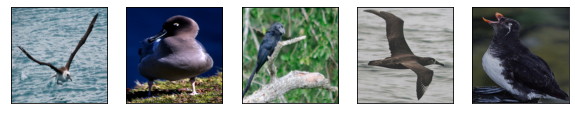

In [8]:
# plt.imshow(crop_img_list[0].transpose(1,2,0))
def draw_image(row,col,img_list,title=None):
    plt.figure(figsize=(10,10)) 
    plt.suptitle(title,fontsize='22')
    for i in range(col*row):
        plt.subplot(row,col,i+1)
        plt.imshow(img_list[i])
        # plt.title(title_list[i])
        plt.xticks([]),plt.yticks([])

draw_image(1,5,[i.transpose(1,2,0) for i in crop_img_list])

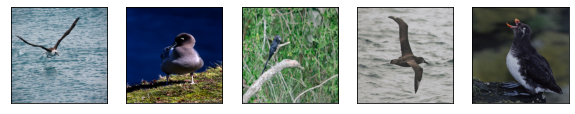

In [9]:
# a = []
# for i in range(img_list.shape[0]):
#     a.append(img_list[i].permute(1,2,0))
# draw_image(1,5,a,'None')
# 对维度更改
channel_change_img=[img_list[i].permute(1,2,0) for i in range(img_list.shape[0])]
draw_image(1,5,channel_change_img,None)

In [10]:
import os
import numpy

from torch import tensor
# img = imageio.imread(path[0])

# if len(img.shape) == 2:
#                 img = np.stack([img] * 3, 2)

# img = Image.fromarray(img,mode="RGB")
# img = transforms.Resize(
#         (448,448),
#         interpolation=InterpolationMode.BICUBIC,
#     )(img)

# img = transforms.RandomHorizontalFlip()(img)
# img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)
# img = transforms.ToTensor()(img)
# # img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(
# #                 img)
# img = img.numpy()

# plt.imshow(img.transpose(1,2,0))
def read_img(path,size):
    img_list =[]
    img_path = [os.path.join(path,i) for i in os.listdir(path)]
    for j in img_path:
        img=imageio.imread(j)
        if len(img.shape) == 2:
                img = np.stack([img] * 3, 2)

        img = Image.fromarray(img,mode="RGB")
        img = transforms.Resize(
                (448,448),
                interpolation=InterpolationMode.BICUBIC,
            )(img)
        img = transforms.RandomHorizontalFlip()(img)
        img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)
        img = transforms.ToTensor()(img)
        # img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(
        #                 img)
        img = img.numpy()
        img_list.append(img)
    return img_list,img_path
img,path = read_img('Dataset/bird/',448)
# plt 输出的格式 要求为 h,w,c
# plt.imshow(img[0].transpose(1,2,0))

<ipython-input-10-42cc5f8d0e93>:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imageio.imread(j)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


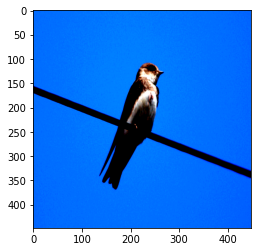

In [11]:
from numpy import dtype
from Dataset.dataset import CUB_self
# 通过数据集的批处理来读取数据
# data = read_dataset(448,3,'/data0/hwl_data/FGVC/CUB-1',"CUB")
plt.imshow(CUB_self(448,'/data0/hwl_data/FGVC/CUB-1')[5][0].permute(1,2,0))

##### 使用 tensorboard 可视化图片列表
  

In [13]:
from tensorboardX import SummaryWriter
import os

with SummaryWriter(log_dir=os.path.join(os.getcwd(),'log'),comment="draw a epoch img") as writer:
    # 输入的 batch 图像列表为 np 类型
    writer.add_images(
        'clip images',
        crop_img_list
    )


使用 `Totensor`会将shape由`H,W,C`变为`C,H,W`

In [16]:
test1 = np.ones((448,448,3))

test2 = transforms.ToTensor()(test1)

print(test2.shape)

torch.Size([3, 448, 448])


In [6]:
import torch
x = torch.randn((3,10))
i,j =x.max(1)
print(j)

tensor([1, 7, 0])


## Gauss混合模型

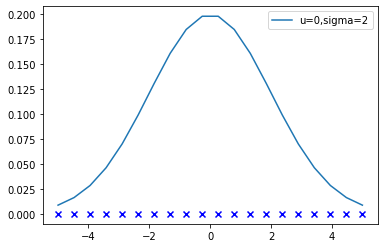

In [26]:
# 高斯模型
from cProfile import label
from scipy.stats import norm
import matplotlib.pyplot as plt


def gauss_show(input):
    gauss1=norm.pdf(input, loc=0, scale=2)
    # loc: mean 均值， scale: standard deviation 标准差
    for i in range(len(input)):
        plt.scatter(input[i], 0,marker ='x',color='blue')
    plt.plot(input,gauss1,label='u=0,sigma=2')
    plt.legend(loc='upper right')
    plt.show()
X1 = np.linspace(-5, 5, num=20)  
gauss_show(X1)

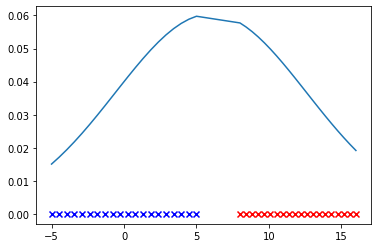

In [27]:
# 两组数据
X2=np.linspace(8, 16, num=20)
#数据合并
X = np.hstack((X1, X2))
gauss=norm.pdf(X, loc=np.mean(X), scale=np.std(X))

for i in range(len(X1)):
    plt.scatter(X1[i], 0,marker ='x',color='blue')
for i in range(len(X2)):
    plt.scatter(X2[i], 0,marker ='x',color='red')
plt.plot(X,gauss)
plt.show()

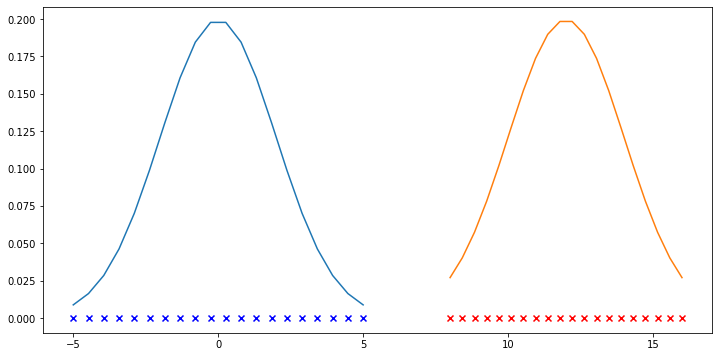

In [31]:
X2=np.linspace(8, 16, num=20)
gauss2=norm.pdf(X2, loc=12, scale=2)
gauss1=norm.pdf(X1, loc=0, scale=2)
plt.figure(figsize=(12, 6))
for i in range(len(X1)):
    plt.scatter(X1[i], 0,marker ='x',color='blue')
plt.plot(X1,gauss1)

for i in range(len(X2)):
    plt.scatter(X2[i], 0,marker ='x',color='red')
plt.plot(X2,gauss2)

plt.show()

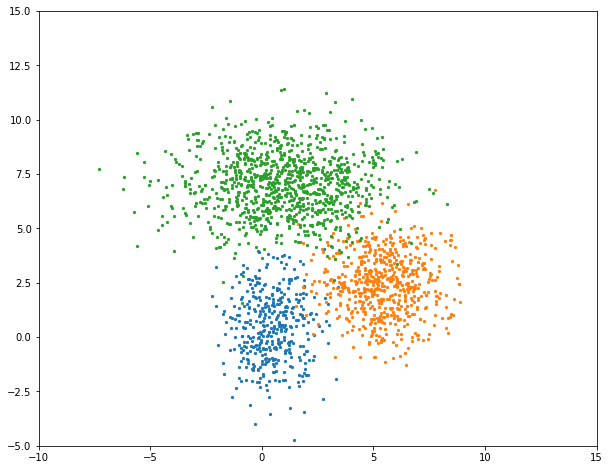

In [47]:
true_Mu = [[0.5, 0.5], [5.5, 2.5], [1, 7]]
true_Var = [[1, 3], [2, 2], [6, 2]]
num1, mu1, var1 = 400, true_Mu[0], true_Var[0]
X1 = np.random.multivariate_normal(mu1, np.diag(var1), num1)
# 第二簇的数据
num2, mu2, var2 = 600, true_Mu[1], true_Var[1]
X2 = np.random.multivariate_normal(mu2, np.diag(var2), num2)
# 第三簇的数据
num3, mu3, var3 = 1000, true_Mu[2], true_Var[2]
X3 = np.random.multivariate_normal(mu3, np.diag(var3), num3)
# 合并在一起
X = np.vstack((X1, X2, X3))
# 显示数据
plt.figure(figsize=(10, 8))
plt.axis([-10, 15, -5, 15])
plt.scatter(X1[:, 0], X1[:, 1], s=5)
plt.scatter(X2[:, 0], X2[:, 1], s=5)
plt.scatter(X3[:, 0], X3[:, 1], s=5)
plt.show()

<ipython-input-38-2c4af59a9250>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X1[:, 0],hist=False, color="blue")
<ipython-input-38-2c4af59a9250>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X2[:, 0],hist=False, color="green")
<ipython-input-38-2c4af59a9250>:13: UserWar

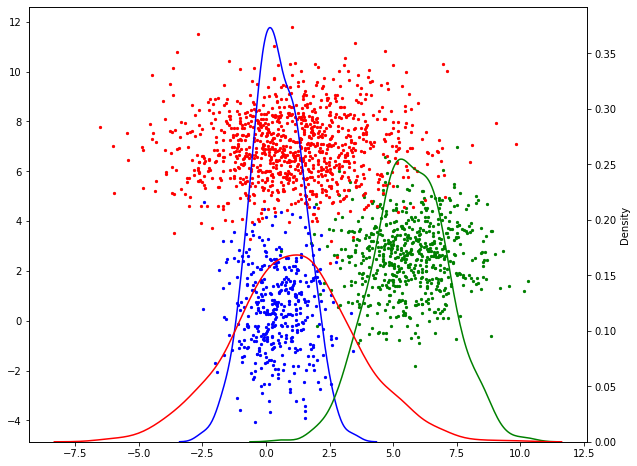

In [38]:
# 显示数据

import seaborn as sns
fig, ax1 = plt.subplots(figsize=(10, 8))

plt.scatter(X1[:, 0], X1[:, 1], s=5, color="blue")
plt.scatter(X2[:, 0], X2[:, 1], s=5, color="green")
plt.scatter(X3[:, 0], X3[:, 1], s=5, color="red")

#副坐标轴
ax2 = ax1.twinx()
sns.distplot(X1[:, 0],hist=False, color="blue")
sns.distplot(X2[:, 0],hist=False, color="green")
sns.distplot(X3[:, 0],hist=False, color="red")

plt.show()


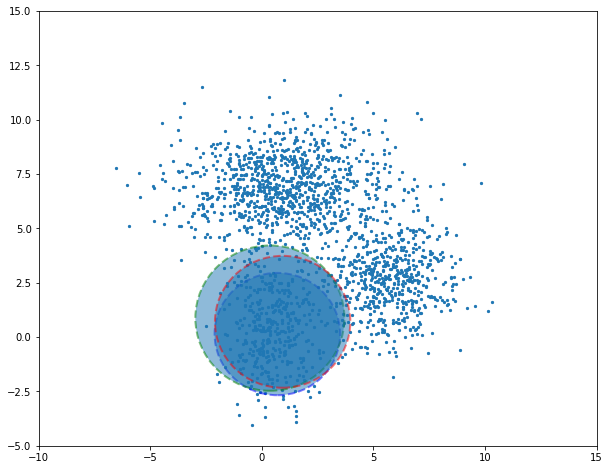

In [45]:
import numpy as np
from scipy import stats
from matplotlib.patches import Ellipse

class GMM(object):
    def __init__(self, k: int, d: int):
        '''
        k: K值即类别数
        d: 样本属性的数量即特征数量,为了可视化本例取2
        '''
        self.K = k
        # 初始化参数
        self.p = np.random.rand(k)
        self.p = self.p / self.p.sum()      # 保证所有p_k的和为1
        self.means = np.random.rand(k, d)#初始化均值
        self.covs = np.empty((k, d, d))#初始化方差
        for i in range(k):                  # 随机生成协方差矩阵，必须是半正定矩阵
            self.covs[i] = np.eye(d) * np.random.rand(1) * k
            
    # 画出聚类图像
    def plot_clusters(self,data,  Mu=None, Var=None):
        colors = ['b', 'g', 'r']
        n_clusters = len(self.means)
        plt.figure(figsize=(10, 8))
        plt.axis([-10, 15, -5, 15])
        plt.scatter(data[:, 0], data[:, 1], s=5)
        ax = plt.gca()
        for i in range(n_clusters):
            #迭代模型区域
            #Ellipse，参数：坐标，椭圆胖瘦
            ellipse = Ellipse(list(self.means[i]), 3 * self.covs[i][0][0], 3 * self.covs[i][1][1],alpha= 0.5 ,lw= 2, edgecolor=colors[i],ls='--')
            
            ax.add_patch(ellipse)
        if (Mu is not None) & (Var is not None):
            #原始数据
            for i in range(n_clusters):
                #plot_args = {'fc': 'None', 'lw': 2, 'edgecolor': colors[i], 'alpha': 0.5}
                ellipse = Ellipse(Mu[i], 3 * Var[i][0], 3 * Var[i][1],  fc='None',lw= 2, edgecolor=colors[i])
                ax.add_patch(ellipse)         
        plt.show()


    def fit(self, data: np.ndarray):
        '''
        data: 数据矩阵,每一行是一个样本,shape = (N, d)
        '''
        for _ in range(100):
            density = np.empty((len(data), self.K))
            for i in range(self.K):
                # 生成K个概率密度函数并计算对于所有样本的概率密度
                norm = stats.multivariate_normal(self.means[i], self.covs[i])
                density[:,i] = norm.pdf(data)
            # 计算所有样本属于每一类别的后验
            posterior = density * self.p#概率*权重
            posterior = posterior / posterior.sum(axis=1, keepdims=True)#归一化:N*3
            #print(posterior)
            # 计算下一时刻的参数值
            p_hat = posterior.sum(axis=0)
            #print(p_hat)
            mean_hat = np.tensordot(posterior, data, axes=[0, 0])#3*N*N*2=3*2
            #print(mean_hat)
            # 计算协方差
            cov_hat = np.empty(self.covs.shape)
            for i in range(self.K):
                tmp = data - self.means[i]
                cov_hat[i] = np.dot(tmp.T*posterior[:,i], tmp) / p_hat[i]
            # 更新参数
            self.covs = cov_hat
            self.means = mean_hat / p_hat.reshape(-1,1)
            self.p = p_hat / len(data)
            if _ % 10 ==0:
                GMM.plot_clusters(X,Mu,Var)
        print(self.p)
        print(self.means)
        print(self.covs)
# GMM(k=3,d=2).fit(X)
GMM(k=3,d=2).plot_clusters(X)

